The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Transferência de Estilo Neural

Se você usa aplicativos de compartilhamento social ou é um fotógrafo amador, está familiarizado com os filtros. Os filtros podem alterar os estilos de cor das fotos para tornar o fundo mais nítido ou o rosto das pessoas mais branco. No entanto, um filtro geralmente só pode alterar um aspecto de uma foto. Para criar a foto ideal, muitas vezes você precisa tentar muitas combinações de filtros diferentes. Esse processo é tão complexo quanto ajustar os hiperparâmetros de um modelo.

Nesta seção, discutiremos como podemos usar redes neurais de convolução (CNNs) para aplicar automaticamente o estilo de uma imagem a outra imagem, uma operação conhecida como transferência de estilo :cite:`Gatys.Ecker.Bethge.2016`. Aqui, precisamos de duas imagens de entrada, uma imagem de conteúdo e uma imagem de estilo. Usamos uma rede neural para alterar a imagem do conteúdo de modo que seu estilo espelhe o da imagem do estilo. Em :numref:`fig_style_transfer`, a imagem do conteúdo é uma foto de paisagem que o autor tirou na Mount Rainier National Part perto de Seattle. A imagem do estilo é uma pintura a óleo de carvalhos no outono. A imagem composta de saída retém as formas gerais dos objetos na imagem de conteúdo, mas aplica a pincelada de pintura a óleo da imagem de estilo e torna a cor geral mais vívida.

![Imagens de entrada de conteúdo e estilo e imagem composta produzida por transferência de estilo. ](../img/style-transfer.svg)
:label:`fig_style_transfer`

## Técnica

O modelo de transferência de estilo baseado em CNN é mostrado em :numref:`fig_style_transfer_model`.
Primeiro, inicializamos a imagem composta. Por exemplo, podemos inicializá-la como a imagem do conteúdo. Esta imagem composta é a única variável que precisa ser atualizada no processo de transferência de estilo, ou seja, o parâmetro do modelo a ser atualizado na transferência de estilo. Em seguida, selecionamos uma CNN pré-treinada para extrair recursos de imagem. Esses parâmetros do modelo não precisam ser atualizados durante o treinamento. O CNN profundo usa várias camadas neurais que extraem sucessivamente recursos de imagem. Podemos selecionar a saída de certas camadas para usar como recursos de conteúdo ou recursos de estilo. Se usarmos a estrutura em :numref:`fig_style_transfer_model`, a rede neural pré-treinada contém três camadas convolucionais. A segunda camada produz os recursos de conteúdo da imagem, enquanto as saídas da primeira e terceira camadas são usadas como recursos de estilo. Em seguida, usamos a propagação para a frente (na direção das linhas sólidas) para calcular a função de perda de transferência de estilo e a propagação para trás (na direção das linhas pontilhadas) para atualizar o parâmetro do modelo, atualizando constantemente a imagem composta. As funções de perda usadas na transferência de estilo geralmente têm três partes: 1. A perda de conteúdo é usada para fazer a imagem composta se aproximar da imagem de conteúdo no que diz respeito aos recursos de conteúdo. 2. A perda de estilo é usada para fazer com que a imagem composta se aproxime da imagem de estilo em termos de recursos de estilo. 3. A perda total de variação ajuda a reduzir o ruído na imagem composta. Finalmente, depois de terminar de treinar o modelo, produzimos os parâmetros do modelo de transferência de estilo para obter a imagem composta final.

![Processo de transferência de estilo baseado em CNN. As linhas sólidas mostram a direção da propagação para a frente e as linhas pontilhadas mostram a propagação para trás. ](../img/neural-style.svg)
:label:`fig_style_transfer_model`


A seguir, faremos um experimento para nos ajudar a entender melhor os detalhes técnicos da transferência de estilo.

## Lendo o Conteúdo e as Imagens de Estilo

Primeiro, lemos o conteúdo e as imagens de estilo. Ao imprimir os eixos de coordenadas da imagem, podemos ver que eles têm dimensões diferentes.


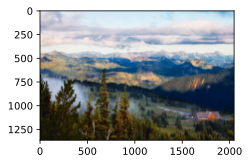

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

d2l.set_figsize()
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

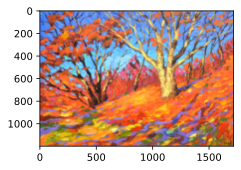

In [2]:
style_img = image.imread('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

## Pré-processamento e Pós-processamento

A seguir, definimos as funções de pré-processamento e pós-processamento de imagens. A função `pré-processamento` normaliza cada um dos três canais RGB das imagens de entrada e transforma os resultados em um formato que pode ser inserido na CNN. A função `postprocess` restaura os valores de pixel na imagem de saída para seus valores originais antes da normalização. Como a função de impressão de imagem requer que cada pixel tenha um valor de ponto flutuante de 0 a 1, usamos a função `clip` para substituir valores menores que 0 ou maiores que 1 por 0 ou 1, respectivamente.


In [3]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)

## Extraindo *Features*

Usamos o modelo VGG-19 pré-treinado no conjunto de dados ImageNet para extrair características da imagem [1].


In [4]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

Para extrair o conteúdo da imagem e os recursos de estilo, podemos selecionar as saídas de certas camadas na rede VGG. Em geral, quanto mais próxima uma saída estiver da camada de entrada, mais fácil será extrair informações detalhadas da imagem. Quanto mais longe uma saída estiver, mais fácil será extrair informações globais. Para evitar que a imagem composta retenha muitos detalhes da imagem de conteúdo, selecionamos uma camada de rede VGG próxima à camada de saída para produzir os recursos de conteúdo da imagem. Essa camada é chamada de camada de conteúdo. Também selecionamos as saídas de diferentes camadas da rede VGG para combinar os estilos local e global. Elas são chamadas de camadas de estilo. Como mencionamos em :numref:`sec_vgg`, as redes VGG têm cinco blocos convolucionais. Neste experimento, selecionamos a última camada convolucional do quarto bloco convolucional como a camada de conteúdo e a primeira camada de cada bloco como camadas de estilo. Podemos obter os índices para essas camadas imprimindo a instância `pretrained_net`.


In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

Durante a extração de *features*, só precisamos usar todas as camadas VGG da camada de entrada até a camada de conteúdo ou estilo mais próxima da camada de saída. Abaixo, construímos uma nova rede, `net`, que retém apenas as camadas da rede VGG que precisamos usar. Em seguida, usamos `net` para extrair *features*.


In [6]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

Dada a entrada `X`, se simplesmente chamarmos a computação direta de `net (X)`, só podemos obter a saída da última camada. Como também precisamos das saídas das camadas intermediárias, precisamos realizar computação camada por camada e reter o conteúdo e as saídas da camada de estilo.


In [7]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

A seguir, definimos duas funções: a função `get_contents` obtém as *features* de conteúdo extraídos da imagem do conteúdo, enquanto a função `get_styles` obtém os recursos de estilo extraídos da imagem de estilo. Como não precisamos alterar os parâmetros do modelo VGG pré-treinado durante o treinamento, podemos extrair as *features* de conteúdo da imagem de conteúdo e recursos de estilo da imagem de estilo antes do início do treinamento. Como a imagem composta é o parâmetro do modelo que deve ser atualizado durante a transferência do estilo, só podemos chamar a função `extract_features` durante o treinamento para extrair o conteúdo e os recursos de estilo da imagem composta.


In [8]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## Definindo a Função de Perda

A seguir, veremos a função de perda usada para transferência de estilo. A função de perda inclui a perda de conteúdo, perda de estilo e perda total de variação.

### Perda de Conteúdo

Semelhante à função de perda usada na regressão linear, a perda de conteúdo usa uma função de erro quadrado para medir a diferença nos recursos de conteúdo entre a imagem composta e a imagem de conteúdo. As duas entradas da função de erro quadrada são ambas saídas da camada de conteúdo obtidas da função `extract_features`.


In [9]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

### Perda de Estilo

A perda de estilo, semelhante à perda de conteúdo, usa uma função de erro quadrático para medir a diferença de estilo entre a imagem composta e a imagem de estilo. Para expressar a saída de estilos pelas camadas de estilo, primeiro usamos a função `extract_features` para calcular a saída da camada de estilo. Supondo que a saída tenha 1 exemplo, $c$ canais, e uma altura e largura de $h$ e $w$, podemos transformar a saída na matriz $\mathbf{X}$, que tem $c$ linhas e $h \cdot w$ colunas. Você pode pensar na matriz $\mathbf{X}$ como a combinação dos vetores $c$ e $\mathbf{x}_1, \ldots, \mathbf{x}_c$, que têm um comprimento de $hw$. Aqui, o vetor $\mathbf{x}_i$ representa a característica de estilo do canal $i$. Na matriz Gram desses vetores $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, elemento $x_{ij}$ na linha $i$ coluna $j$ é o produto interno dos vetores $\mathbf{x}_i$ e $\mathbf{x}_j$. Ele representa a correlação dos recursos de estilo dos canais $i$ e $j$. Usamos esse tipo de matriz de Gram para representar a saída do estilo pelas camadas de estilo. Você deve notar que, quando o valor $h \cdot w$ é grande, isso geralmente leva a valores grandes na matriz de Gram. Além disso, a altura e a largura da matriz de Gram são o número de canais $c$. Para garantir que a perda de estilo não seja afetada pelo tamanho desses valores, definimos a função `gram` abaixo para dividir a matriz de Gram pelo número de seus elementos, ou seja, $c \cdot h \cdot w$.


In [10]:
def gram(X):
    num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
    X = X.reshape((num_channels, n))
    return np.dot(X, X.T) / (num_channels * n)

Naturalmente, as duas entradas de matriz de Gram da função de erro quadrado para perda de estilo são obtidas da imagem composta e das saídas da camada de estilo de imagem de estilo. Aqui, assumimos que a matriz de Gram da imagem de estilo, `gram_Y`, foi calculada antecipadamente.


In [11]:
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

### Perda de Variância Total

Às vezes, as imagens compostas que aprendemos têm muito ruído de alta frequência, principalmente pixels claros ou escuros. Um método comum de redução de ruído é a redução total de ruído na variação. Assumimos que $x_ {i, j}$ representa o valor do pixel na coordenada $(i, j)$, então a perda total de variância é:

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|.$$

Tentamos tornar os valores dos pixels vizinhos tão semelhantes quanto possível.


In [12]:
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Função de Perda

A função de perda para transferência de estilo é a soma ponderada da perda de conteúdo, perda de estilo e perda total de variância. Ajustando esses hiperparâmetros de peso, podemos equilibrar o conteúdo retido, o estilo transferido e a redução de ruído na imagem composta de acordo com sua importância relativa.


In [13]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## Criação e inicialização da imagem composta

Na transferência de estilo, a imagem composta é a única variável que precisa ser atualizada. Portanto, podemos definir um modelo simples, `GeneratedImage`, e tratar a imagem composta como um parâmetro do modelo. No modelo, a computação direta retorna apenas o parâmetro do modelo.


In [14]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

A seguir, definimos a função `get_inits`. Esta função cria uma instância de modelo de imagem composta e a inicializa na imagem `X`. A matriz de Gram para as várias camadas de estilo da imagem de estilo, `styles_Y_gram`, é calculada antes do treinamento.


In [15]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## Treinamento

Durante o treinamento do modelo, extraímos constantemente o conteúdo e as *features* de estilo da imagem composta e calculamos a função de perda. Lembre-se de nossa discussão sobre como as funções de sincronização forçam o *front-end* a esperar pelos resultados de computação em :numref:`sec_async`. Como apenas chamamos a função de sincronização `asnumpy` a cada 10 épocas, o processo pode ocupar uma grande quantidade de memória. Portanto, chamamos a função de sincronização `waitall` durante cada época.


In [16]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        npx.waitall()
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

Em seguida, começamos a treinar o modelo. Primeiro, definimos a altura e a largura das imagens de conteúdo e estilo para 150 por 225 pixels. Usamos a imagem de conteúdo para inicializar a imagem composta.


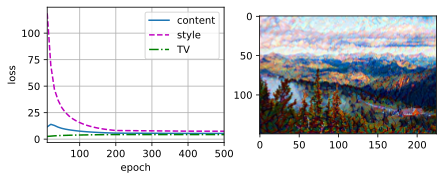

In [17]:
device, image_shape = d2l.try_gpu(), (225, 150)
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

Como você pode ver, a imagem composta retém o cenário e os objetos da imagem de conteúdo, enquanto introduz a cor da imagem de estilo. Como a imagem é relativamente pequena, os detalhes são um pouco confusos.

Para obter uma imagem composta mais clara, treinamos o modelo usando um tamanho de imagem maior: $900 \times 600$. Aumentamos a altura e a largura da imagem usada antes por um fator de quatro e inicializamos uma imagem composta maior.


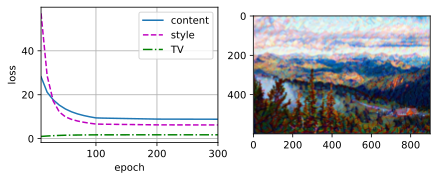

In [18]:
image_shape = (900, 600)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, device, 0.01, 300, 100)
d2l.plt.imsave('../img/neural-style.jpg', postprocess(output).asnumpy())

Como você pode ver, cada época leva mais tempo devido ao tamanho maior da imagem. Conforme mostrado em :numref:`fig_style_transfer_large`, a imagem composta produzida retém mais detalhes devido ao seu tamanho maior. A imagem composta não só tem grandes blocos de cores como a imagem de estilo, mas esses blocos têm até a textura sutil de pinceladas.

![Imagem $900 \times 600$ composta. ](../img/neural-style.jpg)
:width:`500px`
:label:`fig_style_transfer_large`

## Resumo

* As funções de perda usadas na transferência de estilo geralmente têm três partes: 1. A perda de conteúdo é usada para fazer a imagem composta se aproximar da imagem de conteúdo no que diz respeito aos recursos de conteúdo. 2. A perda de estilo é usada para fazer com que a imagem composta se aproxime da imagem de estilo em termos de recursos de estilo. 3. A perda total de variação ajuda a reduzir o ruído na imagem composta.
* Podemos usar um CNN pré-treinado para extrair recursos de imagem e minimizar a função de perda para atualizar continuamente a imagem composta.
* Usamos uma matriz de Gram para representar a saída do estilo pelas camadas de estilo.


## Exercícios

1. Como a saída muda quando você seleciona diferentes camadas de conteúdo e estilo?
1. Ajuste os hiperparâmetros de peso na função de perda. A saída retém mais conteúdo ou tem menos ruído?
1. Use imagens de conteúdo e estilo diferentes. Você pode criar imagens compostas mais interessantes?
1. Podemos aplicar transferência de estilo para texto? Dica: você pode consultar o documento de pesquisa de Hu et al. :cite:`Hu.Lee.Aggarwal.2020`.


[Discussões](https://discuss.d2l.ai/t/378)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTQzMjg2MTE4NSwtMTQ2MjIzMTExNSwxOD
I1NjMwNjcxLDkyNzY3Nzg1OCwyODkzNzY5ODAsLTg0MTQ5NTk5
MiwtOTMzOTI1NjIsLTI2OTA2NDgzNSwxODkxNDEzNTEwXX0=
-->
